In [1]:
import numpy as np
import pandas as pd
import itertools
import gc
import psycopg2
import getpass
# for configuring connection 
from configobj import ConfigObj
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *

In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = '192.168.60.144'
    conn_info["sqlport"] = 6432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == '192.168.60.144') & (conn_info["sqlport"]=='6432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: postgres


In [3]:
from sqlalchemy import create_engine,text

con = create_engine(
    f'postgresql://{conn_info["sqluser"]}:{conn_info["sqlpass"]}@{conn_info["sqlhost"]}:{conn_info["sqlport"]}/{conn_info["dbname"]}',
    connect_args={'options': '-c search_path=eicu_crd'}
)

In [4]:
create_table_query =  query_schema +"""
drop materialized view if exists risk cascade;
create materialized view risk as
  select id.patient, id.time, l.gender, l.age, l.dischargeweight,l.unitdischargestatus, l.discharge_risk_category, l.actualiculos 
    from labels as l
    inner join id  on id.patient = l.patient  
    order by id.patient, id.time; 

"""

with con.begin() as connection:
    connection.execute(text(create_table_query)) 

select_query = "SELECT * FROM risk;"
df_risk = pd.read_sql_query(select_query, con)

print("there are {} patiets and {} records in lab test table".format(df_risk["patient"].nunique(),df_risk["patient"].count()))

there are 3072 patiets and 4486431 records in lab test table


In [5]:
df_risk

,patient,time,gender,age,dischargeweight,unitdischargestatus,discharge_risk_category,actualiculos
0,260132,1,0,89.0,84.1,1,3,0.1819
1,260132,2,0,89.0,84.1,1,3,0.1819
2,260132,3,0,89.0,84.1,1,3,0.1819
3,260132,4,0,89.0,84.1,1,3,0.1819
4,260132,5,0,89.0,84.1,1,3,0.1819
...,...,...,...,...,...,...,...,...
4486426,3247116,2328,0,52.0,68.0,1,3,8.1256
4486427,3247116,2329,0,52.0,68.0,1,3,8.1256
4486428,3247116,2330,0,52.0,68.0,1,3,8.1256
4486429,3247116,2331,0,52.0,68.0,1,3,8.1256


In [6]:
risk_category_counts = df_risk['discharge_risk_category'].value_counts().sort_index()
risk_category_counts

discharge_risk_category
0     113332
1    3183908
2     827206
3     361985
Name: count, dtype: int64

In [7]:
def risk_function(t, category):
    if category == 0:
        return  0.4 * (1 - np.exp(-0.0003 * t)) + 0
    elif category == 1:
        return  (0.2-0.45) * (np.exp(-0.00045 * t)) + 0.45
    elif category == 2:
        return  (0.4-0.55) * ( np.exp(-0.00055 * t)) + 0.55
    elif category == 3:
        return  ((1.0-0.6)) * ( np.exp(-0.0006 * t)) + 0.6

In [8]:
max_time_per_patient = df_risk.groupby('patient')['time'].transform('max')
df_risk['risk_score'] = df_risk.apply(lambda row: risk_function(max_time_per_patient[row.name] - row['time'], row['discharge_risk_category']), axis=1)
df_risk

,patient,time,gender,age,dischargeweight,unitdischargestatus,discharge_risk_category,actualiculos,risk_score
0,260132,1,0,89.0,84.1,1,3,0.1819,0.989578
1,260132,2,0,89.0,84.1,1,3,0.1819,0.989812
2,260132,3,0,89.0,84.1,1,3,0.1819,0.990046
3,260132,4,0,89.0,84.1,1,3,0.1819,0.990280
4,260132,5,0,89.0,84.1,1,3,0.1819,0.990514
...,...,...,...,...,...,...,...,...,...
4486426,3247116,2328,0,52.0,68.0,1,3,8.1256,0.999041
4486427,3247116,2329,0,52.0,68.0,1,3,8.1256,0.999281
4486428,3247116,2330,0,52.0,68.0,1,3,8.1256,0.999520
4486429,3247116,2331,0,52.0,68.0,1,3,8.1256,0.999760


In [9]:
hdf= '/home/mei/nas/docker/thesis/data/hdf/'
merged = df_risk.copy()
merged.to_hdf(hdf + 'final_risk_scores.h5', key='df',complevel=5, complib="zlib")
# merged = pd.read_hdf(hdf + 'final_risk_scores.h5', key='df')

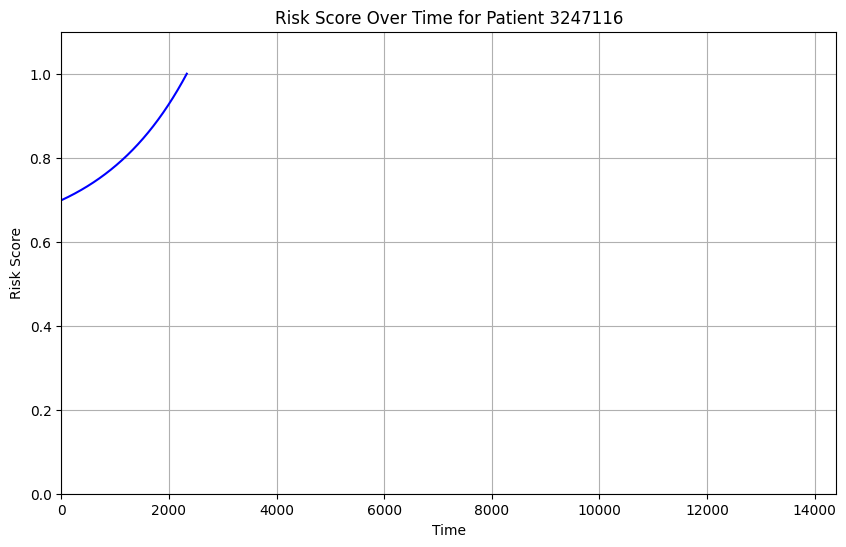

In [10]:
patient_id =3247116

patient_data = merged[merged['patient'] == patient_id]
patient_2 = merged[merged['patient'] == 252784]

plt.figure(figsize=(10, 6))
plt.plot(patient_data['time'], patient_data['risk_score'],label="Low risk", color="blue")
plt.plot(patient_2['time'], patient_2['risk_score'], label="medium risk" ,color="orange")
plt.title(f'Risk Score Over Time for Patient {patient_id}')
plt.xlabel('Time')
plt.xlim(0,10* 24 * 60) 
plt.ylim(0, 1.1)
plt.ylabel('Risk Score')
plt.grid(True)
plt.show()

